In [1]:
# optimal PID controller tuning
# Victor M. Zavala
# UW-Madison, 2017

using Ipopt
using Plasmo
using JuMP
using PyPlot

MPI.Init()  # Initialize MPI

# sets
NS=3;       # Number of scenarios 
 N=100;     # Number of timesteps
Tf=10;      # Final time
 h=Tf/N;    # Time step
 T=1:N;     # Set of times
Tm=1:N-1;   # Set of times minus one

# set time vector
time=zeros(N);
for t=1:N
 time[t] = h*(t-1);
end

# scenario data
K=zeros(NS);   # system gain
x0=zeros(NS);  # initial state
Kd=zeros(NS);  # disturbance gain
tau=zeros(NS); # time constaint
xsp=zeros(NS); # set-point
d=zeros(NS);   # disturbance 

  K[1] =  1.0;
 x0[1] =  0.0;
 Kd[1] =  0.5;
tau[1] =  1.0;
xsp[1] = -1.0;
  d[1] = -1.0;

  K[2] =  1.0;
 x0[2] =  0.0;
 Kd[2] =  0.5;
tau[2] =  1.0;
xsp[2] = -2.0;
  d[2] = -1.0;

  K[3] =  1.0;
 x0[3] =  0.0;
 Kd[3] =  0.5;
tau[3] =  1.0;
xsp[3] =  1.0;
  d[3] = -1.0;

include("createPIDmodel.jl")  #scenario model building function

# create two-stage graph moddel
PID=GraphModel()
master = Model()
master_node = add_node(PID,master)

# add variables to parent node 
@variable(master, -10<= Kc <=10)
@variable(master,-100<=tauI<=100)
@variable(master,-100<=tauD<=1000)

# create array of children models
PIDch=Array{NodeOrEdge}(NS)
for s in 1:NS           
           # get scenario model
           bl = get_scenario_model(s)
           child = add_node(PID,bl)
           # add children to parent node
           PIDch[s] = child
           # link children to parent variables
           @linkconstraint(PID, bl[:Kc]==Kc)
           @linkconstraint(PID, bl[:tauI]==tauI)
           @linkconstraint(PID, bl[:tauD]==tauD)    
end

# solve with PipsNlp
pipsnlp_solve(PID,master_node,PIDch)

# get controller parameters
println(getvalue(Kc))
println(getvalue(tauI))
println(getvalue(tauD))

# plot responses
x=zeros(NS,N)
for s in 1:NS
    for j=1:N
    x[s,j]=getvalue(getindex(PIDch[s],:x)[j]) 
    end
end

MPI.Finalize()

load option file: pipsnlp.parameter 
OPTION: Set DoIR_Aug to 1
OPTION: Set DoIR_Full to 0
OPTION: Set printing level to 2
OPTION: Set Iteration Limit to 500
OPTION: Set Convergence Tolerance to 1.00e-06
OPTION: Max Line search step:   50
OPTION: Set Sym linear solver as MA57.
OPTION: MA57 pivot level = 1.00e-04
OPTION: MA57 ordering method = 5, (see doc)
OPTION: Do IR on Aug sys.
OPTION: Set MaxIR to 10
OPTION: Set IRtol to 1.00e-12
OPTION: Require small constraint violation in SWC 
  
  -----------------------------------------------
  NLP Solver 
  Argonne National Laboratory, 2016
  -----------------------------------------------


  Linear system solver ------	 Ma57.

solving ...
1st stage 3 variables, 0 equality constraints, 0 inequality constraints.
2nd stage (use 1st scenario): 403 variables, 402 equality constraints, 0 inequality constraints.
3 scenarios.
Total 1212 variables, 1206 equality constraints, 0 inequality constraints. 

 Iter	  Objective     Inf_pr	  Inf_du     Comp 

4.318251548542441
2.247807348871571
-3.1005666551172224


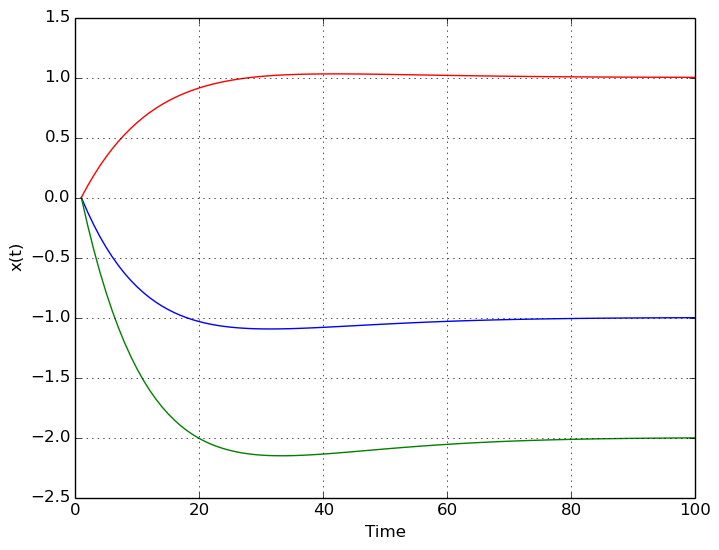

In [2]:
plot(T, x[1,:]);
plot(T, x[2,:]);
plot(T, x[3,:]);
xlabel("Time")
ylabel("x(t)")
grid("on")